# KMeans in CUDA w/ Python Demo

### Setup
- "clustering.py" is the file that contains the KMeans wrapper class
- clustering.py makes use of kmeans.so which is build from kmeans.cu and kmeansHelper.cu for CUDA implementation of Kmeans fitting/labeling data
- all files were in the same directory when running prior to submission (i.e. kmeans.cu, kmeansHelper.cu, kmeans.so, iris_nb.ipynb, clustering.py)


In [19]:
# Load modules and import iris dataset
from clustering import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as skKMeans
import time

data = pd.read_csv('iris.csv',header=None)
data.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [13]:
model = KMeans(k=3, iterations=20, timing=True)
model.fit(data)

initalized kmeans with k =  3 , itr =  20
mxn:  150 x 4
Time to fit model:  0.0011794567108154297


array([[5.00784314, 3.4       , 1.49411765, 0.26078431],
       [6.06      , 2.8175    , 4.6425    , 1.5775    ],
       [7.17368421, 3.12105263, 6.11578947, 2.12105263]])

In [14]:
labels = model.label(data)

Time to label datapoints:  0.0006184577941894531


### Comparison to sklearn's sequential algorithm

In [15]:
model = skKMeans(n_clusters=3, max_iter=20)
start = time.time()
model.fit(data)
end = time.time()
print('Time for sklearn to fit kmeans', end-start)

Time for sklearn to fit kmeans 0.01977229118347168


## Visualization of Results for Verification of Clustering Algorithm

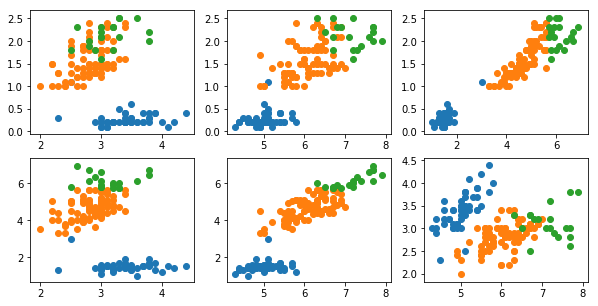

In [16]:
pairs = set([''.join(str(x) for x in sorted((i,j))) for i in range(4) for j in range(4) if i!=j])

f, ax = plt.subplots(2, 3,figsize=(10,5))

for i, pair in enumerate(pairs):
    x = int(pair[0])
    y = int(pair[1])
    pltr = ax[i%2,i%3]
    pltr.scatter(data[labels==0][x],data[labels==0][y])
    pltr.scatter(data[labels==1][x],data[labels==1][y])
    pltr.scatter(data[labels==2][x],data[labels==2][y])

<video controls src="kmeans.mov">

## Code sample from clustering.py (CUDA Python Binding)


```python
class KMeans:

     def __init__(self, k=3, iterations=10, timing=False):
         self.k_ = k
         self.itr_ = iterations
         self.centroids_ = None
         self.dylib = ctypes.CDLL('./kmeans.so')
         print('initalized kmeans with k = ',k,', itr = ',iterations)
         self.timeflag = timing

     def fit(self, data):
         data = np.array(data, dtype=float)
         m = data.shape[0]
         if(len(data.shape)>1):
             n = data.shape[1]
         else:
             n = 1
         print('mxn: ',m,'x',n)
         data = np.reshape(data,(m*n,))
         data = data.astype(c_double)
         self.centroids_ = np.zeros(self.k_*n).astype(c_double)
         func = self.dylib.kmeans
         func.argtypes = [POINTER(c_double), c_size_t, c_size_t, c_size_t, POINTER(c_double), c_size_t]
         if(self.timeflag):
             start = time.time()
         func(data.ctypes.data_as(POINTER(c_double)), m, n, self.k_, self.centroids_.ctypes.data_as(POINTER(c_double)), self.itr_)         if(self.timeflag):
             end = time.time()
             print('Time to fit model: ', end - start)

         self.centroids_ = np.reshape(self.centroids_, (self.k_, n))
         return self.centroids_
```

## CUDA Kmeans Fit Function (Iterating over assignment and update kmeans)

```c
   for(int step__ = 0; step__ < iterations; step__++){
   
         // Assignment Step
         init_zeros<<<m, 1>>>(distances);
         assignClasses<<<m, 1>>>(data_d, centroids_d, m, n, k, labels, distances);

         // Update Means Step
         init_zeros<<<k, 1>>>(counts);
         init_zeros<<<k, n>>>(new_mean);
         findNewCentroids<<<m, n>>>(data_d, centroids_d, labels, m, n, k, counts);
         divide_by_count<<<k, n>>>(new_mean, counts, n, k);

     }
```

## Example CUDA Kernel for assigning classes (called by m total threads, one per observation)

```c
__global__ void assignClasses(double *data, double *means, int m, int n, int k, int*labels, double*distances){

     int idx = blockIdx.x * blockDim.x + threadIdx.x;
     int distance = 0;
     for(int ki = 0; ki < k; ki++){
         for(int i = 0; i < n; i++){
             distance += (data[idx*n + i]-means[ki*n + i])*(data[idx*n + i]-means[ki*n + i]);
         }
         if (ki == 0 || distance < distances[idx]){
             labels[idx] = ki;
             distances[idx] = distance;
         }
         distance = 0;
     }
 }
```